In [1]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter  # 导入SummaryWriter

import grid_env
from model import *
from render import *

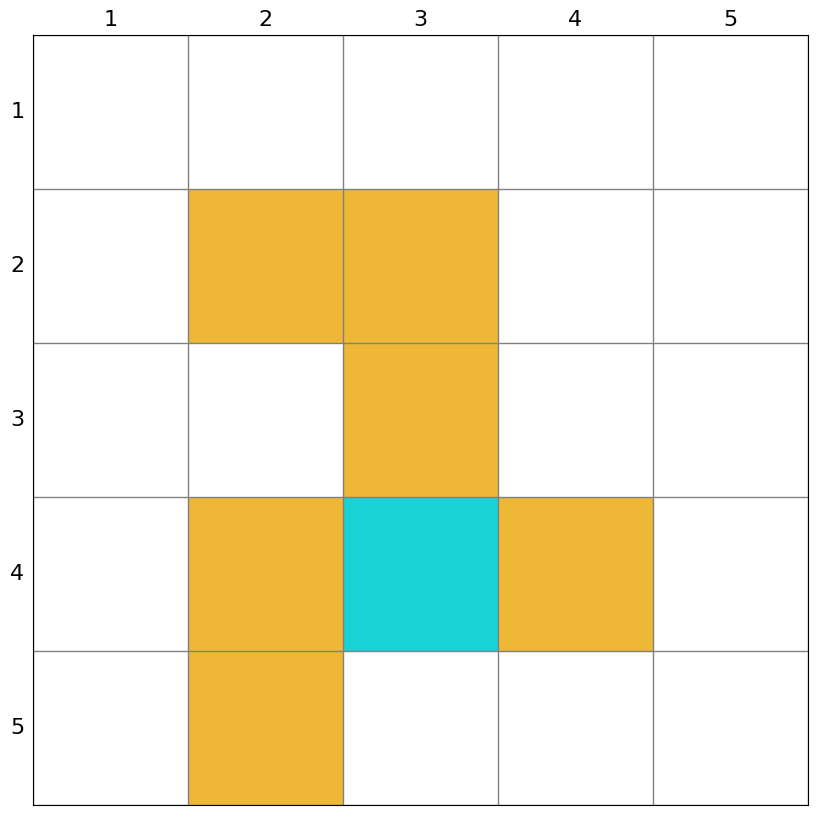

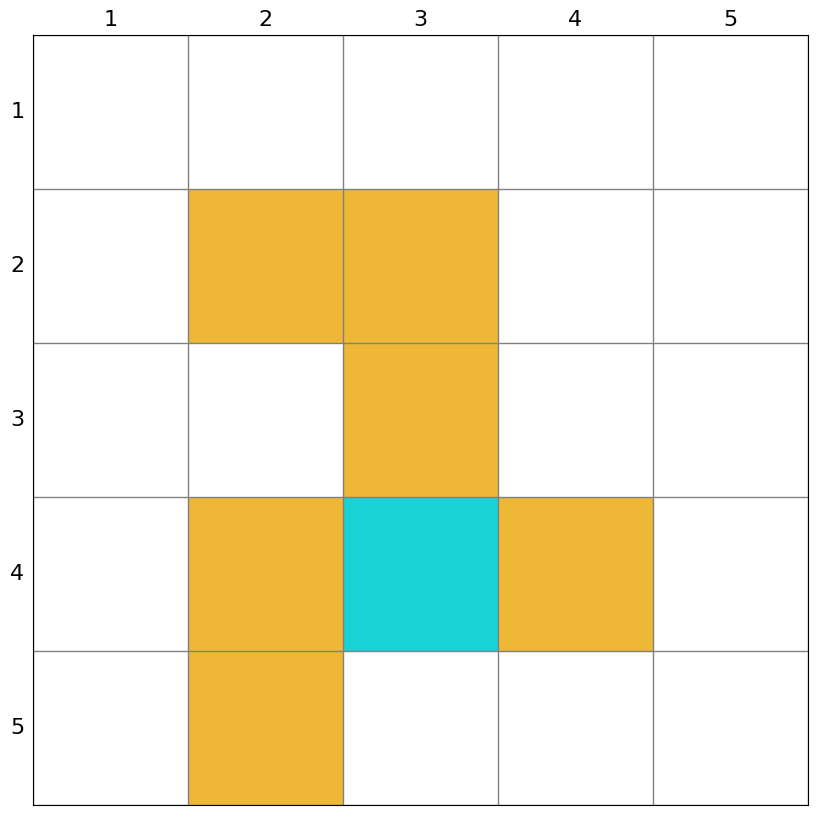

In [2]:
env1 = grid_env.GridEnv(size=5, target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], render_mode='')
env2 = grid_env.GridEnv(size=5, target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], render_mode='')

In [3]:
def obtain_episode(env, policy, start_state, start_action, length):
        f"""

        :param policy: 由指定策略产生episode
        :param start_state: 起始state
        :param start_action: 起始action
        :param length: episode 长度
        :return: 一个 state,action,reward,next_state,next_action 序列
        """
        env.agent_location = env.state2pos(start_state)
        episode = []
        next_action = start_action
        next_state = start_state
        while length > 0:
            length -= 1
            state = next_state
            action = next_action
            _, reward, done, _, _ = env.step(action)
            next_state = env.pos2state(env.agent_location)
            next_action = np.random.choice(np.arange(len(policy[next_state])),
                                           p=policy[next_state])
            episode.append({"state": state, "action": action, "reward": reward, "next_state": next_state,
                            "next_action": next_action})
        return episode

In [4]:
def Q_learning_off_policy(env, alpha = 0.01 , episode_length=2000 , gamma = 0.9):
    state_space_size = env.size ** 2
    action_space_size = env.action_space_size
    env.reset()
    start_state = env.pos2state(env.agent_location)
    policy = np.ones((state_space_size, action_space_size)) / action_space_size
    start_action = np.random.choice(np.arange(action_space_size),p=policy[start_state])
    # 初始化策略为均匀分布
    episode = obtain_episode(env,policy, start_state=start_state, start_action=start_action,
                                      length=episode_length)
    # 初始化Q值为零矩阵
    qvalue = np.zeros((state_space_size, action_space_size))
    for step in range(len(episode) - 1):
        reward = episode[step]['reward']
        state = episode[step]['state']
        action = episode[step]['action']
        next_state = episode[step + 1]['state']
        next_action = qvalue[next_state].max()
        target = reward + gamma * next_action
        error = qvalue[state , action] - target
        qvalue[state , action] -= alpha * error
        action_star = qvalue[state].argmax()
        policy[state] = np.zeros(action_space_size)
        policy[state][action_star] = 1
    
    return policy

In [5]:
def Q_learning_on_policy(env, alpha = 0.001 , epsilon = 0.8 , num_episode = 1000 , gamma = 0.9):
    state_space_size = env.size ** 2
    action_space_size = env.action_space_size
    env.reset()
    policy = np.ones((state_space_size, action_space_size)) / action_space_size
    qvalue = np.zeros((state_space_size, action_space_size))
    while num_episode > 0:
        done = False
        env.reset()
        next_state = 0
        total_reward = 0
        episode_length = 0
        num_episode -= 1
        while not done:
            state = next_state
            action = np.random.choice(np.arange(action_space_size),p = policy[state])
            _,reward,done,_,_ = env.step(action)
            next_state = env.pos2state(env.agent_location)
            episode_length += 1
            total_reward += reward
            next_qvalue_star = qvalue[next_state].max()
            target = reward + gamma * next_qvalue_star
            error = qvalue[state , action] - target
            qvalue[state, action] = qvalue[state, action] - alpha * error
            qvalue_star = qvalue[state].max()
            action_star = qvalue[state].tolist().index(qvalue_star)
            for a in range(action_space_size):
                if a == action_star:
                    policy[state , a] = 1 - (action_space_size - 1) / action_space_size * epsilon
                else:
                    policy[state, a] = 1 / action_space_size * epsilon
    return policy

In [6]:
policy1 = Q_learning_off_policy(env1)
policy2 = Q_learning_on_policy(env2)

e:\Reinforcement_learning\scripts\render.py:153: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


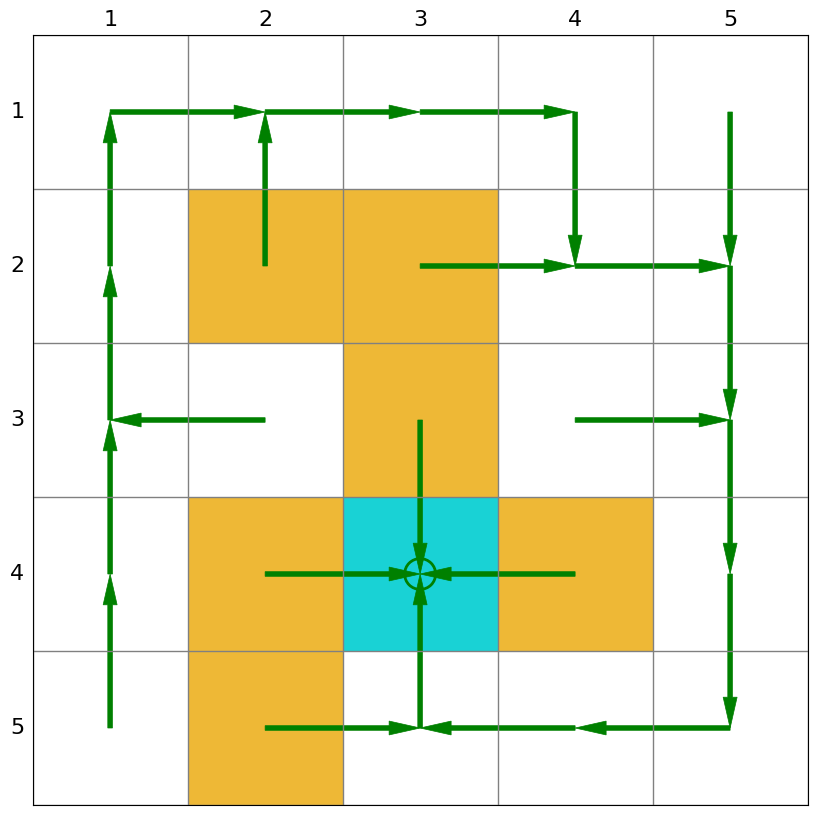

In [7]:
# 定义动作对应的方向
action_to_direction = {
    0: np.array([-1, 0]),
    1: np.array([0, 1]),
    2: np.array([1, 0]),
    3: np.array([0, -1]),
    4: np.array([0, 0]),
}
render = Render(target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], size=5)
# 绘制每个状态的最优动作
for state in range(policy1.shape[0]):
    # 计算状态在网格中的位置
    row, col = env1.state2pos(state)
    
    # 找出当前状态下的最优动作
    best_action = np.argmax(policy1[state])
    
    # 根据最优动作绘制箭头
    render.draw_action(pos=[row, col], toward=action_to_direction[best_action])

# 显示结果
render.show_frame()

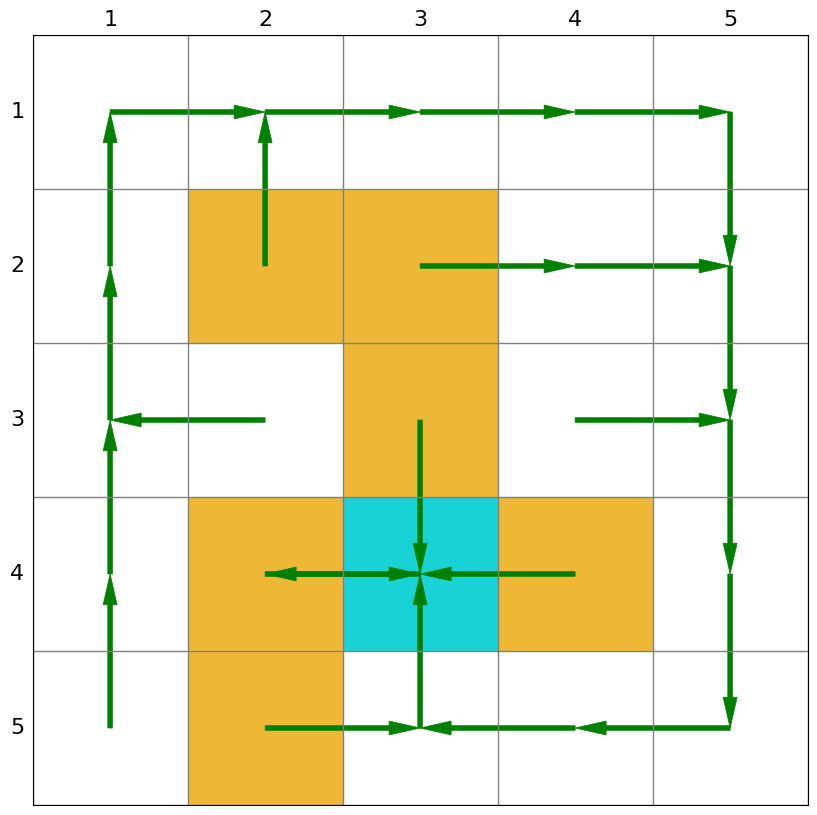

In [8]:
# 定义动作对应的方向
action_to_direction = {
    0: np.array([-1, 0]),
    1: np.array([0, 1]),
    2: np.array([1, 0]),
    3: np.array([0, -1]),
    4: np.array([0, 0]),
}
render = Render(target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], size=5)
# 绘制每个状态的最优动作
for state in range(policy2.shape[0]):
    # 计算状态在网格中的位置
    row, col = env2.state2pos(state)
    
    # 找出当前状态下的最优动作
    best_action = np.argmax(policy2[state])
    
    # 根据最优动作绘制箭头
    render.draw_action(pos=[row, col], toward=action_to_direction[best_action])

# 显示结果
render.show_frame()